### gCDMI: Causal Discovery in Groups of Multivariate Timeseries

Notebook written by Wasim Ahmad <br> Computer Vision Group (CVG) <br> FSU Jena, Germany <br> Last updated on: May 02, 2024


The purpose of this notebook is to provide a simple usage example of the `gCDMI` for generating causal graph for mulativariate time series. Higher-dimensional time series may require additional computational time or the availaibility of a graphical processing unit.

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

#### Load Dependencies

In [183]:
import pickle
import time
import pathlib
import pcmci
import parameters
import gcdmi
import renyiDAG
import numpy as np
import mxnet as mx
import pandas as pd
import preprocessing as prep
import matplotlib.pyplot as plt
from knockoffs import Knockoffs
from gctest2 import groupCause
from gluonts.trainer import Trainer
from scms import StructuralCausalModel
from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from statsmodels.tsa.seasonal import seasonal_decompose
from gluonts.distribution.multivariate_gaussian import MultivariateGaussianOutput

In [184]:
np.random.seed(1)
mx.random.seed(2)

#### Load Model Parameters

The parameters for model archicture varies from application to application depends on data dimensionality mainly

In [209]:
start_time = time.time()

# Parameters
pars = parameters.get_rivernet_params_gc()
freq = pars.get('freq')
epochs = pars.get('epochs')
win_size = pars.get('win_size')
slidingwin_size = pars.get('slidingwin_size')
training_length = pars.get('train_len')
prediction_length = pars.get('pred_len')
num_samples = pars.get('num_samples')
num_layers = pars.get('num_layers')
num_cells = pars.get('num_cells')
dropout_rate = pars.get('dropout_rate')
batch_size = pars.get('batch_size')
plot_path = pars.get('plot_path')
model_name = pars.get('model_name')

In [210]:
# data = prep.load_flux_data(0, 96)
# data.head()

In [242]:
df, ground_truth, _ = prep.load_rivernet(4)
df.columns = [f'R{col}' for col in df.columns]

Ground truth: 
 [[0 0 0 0 1]
 [0 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]]
                 154       891       893       894       895
datetime                                                    
2019-01-01  0.534667  2.480000  1.407292  4.707292  1.945729
2019-01-02  0.524135  2.480000  1.399479  4.749271  1.937708
2019-01-03  0.481688  2.324688  1.328958  4.590833  1.843437
2019-01-04  0.432000  2.270000  1.302292  4.517292  1.784167
2019-01-05  0.463958  2.261250  1.313125  4.533750  1.831042


<Axes: xlabel='datetime'>

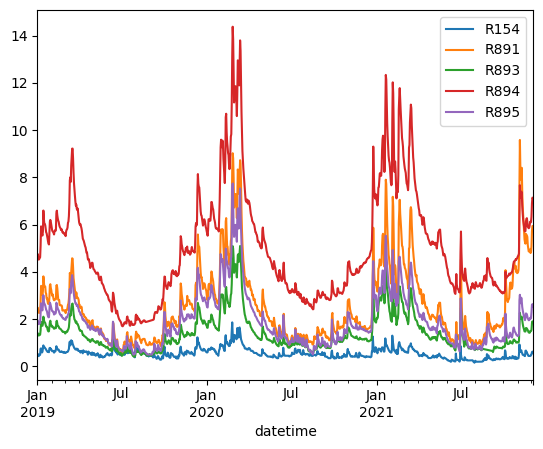

In [249]:
df.loc['2019-01-01':'2021-12-05'].plot()

In [ ]:
series = df[154]

# Perform seasonal decomposition (frequency=365 for yearly cycle)
decomposition = seasonal_decompose(series, model='additive', period=365)

# Plot the decomposition
decomposition.plot()
plt.show()

# Remove the seasonal component by subtracting the seasonal component
deseasonalized = series - decomposition.seasonal

# Display the deseasonalized series
print(deseasonalized)

# Plot the deseasonalized data
plt.figure(figsize=(10, 6))
plt.plot(deseasonalized, label='Deseasonalized Data')
plt.legend()
plt.title("Deseasonalized Time Series")
plt.show()

#### Load Dataset

In [212]:
# df = prep.load_syn_data()
# df = df.iloc[:, :]
# df[:100].plot(figsize=(9, 4), linewidth=0.66, use_index=True)
# plt.show()
# # func.corr_heatmap(df)
# df.head()

In [213]:
# # --------------------------------------
# #           Erdos-Renyi DAG
# # --------------------------------------
# np.random.seed(1)
# nodes = 6
# num_groups = 6
# group_size = int(nodes/num_groups)
# nonlinearity_factor = 0.25
# interaction_density = 0.11
# timesteps = 33

# df, causalgraph, complete_graph = renyiDAG.generate_dag_and_time_series(nodes, interaction_density, nonlinearity_factor, timesteps, num_groups, group_size)

#### Generate Training Dataset

In [214]:
original_data = []
dim, columns = len(df.columns), df.columns
for col in df:
    original_data.append(df[col])

original_data = np.array(original_data)
# training set
train_ds = ListDataset(
    [
        {'start': "01/03/2015 00:00:00",
         'target': original_data[:, 0: training_length].tolist()
         }
    ],
    freq=freq,
    one_dim_target=False
)

#### DeepAR Estimator

In [215]:
# create estimator
estimator = DeepAREstimator(
    prediction_length=prediction_length,
    context_length=prediction_length,
    freq=freq,
    num_layers=num_layers,
    num_cells=num_cells,
    dropout_rate=dropout_rate,
    trainer=Trainer(
        ctx="cpu",
        epochs=epochs,
        hybridize=False,
        batch_size=32
    ),
    distr_output=MultivariateGaussianOutput(dim=dim)
)

### Load/Train Model

In [218]:
path = pars.get('model_path')
model_name = 'rivernet_1.sav'
model_path = pathlib.Path(path + model_name)
# model_path = "../models/trained_model_georegime_cli9.sav"
# model_path = "../models/trained_model_syn22Sep.sav"
# model_path = "../models/trained_model_river16Jun.sav"

filename = pathlib.Path(model_path)
print(f'Model: {filename}')
if not filename.exists():
    print('Training DeepAR model....')
    predictor = estimator.train(train_ds)
    # save the model to disk
    pickle.dump(predictor, open(filename, 'wb'))

Model: /home/ahmad/Projects/gCause/models/gc/rivernet_1.sav


#### Generate Knockoffs

In [219]:
data_actual = np.array(original_data[:, :]).transpose()
n = len(original_data[:, 0])
obj = Knockoffs()
pars.update({'length': n, 'dim': dim, 'col': columns})
knockoffs = obj.Generate_Knockoffs(data_actual, pars)

#### Esimate Causal Links

Select number of groups: 5
Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 1 --------------> Group: 1 (R553)
----------*****-----------------------*****------------
Test statistic: 1.0, pv-dist: 0.0, pv-corr: 0.34, kld: 0.197
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.02
----------*****-----------------------*****------------
Causal Link: Group: 1 --------------> Group: 1 (R553)
----------*****-----------------------*****------------
Test statistic: 1.0, pv-dist: 0.0, pv-corr: 0.34, kld: 0.197
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.03
----------*****-----------------------*****------------
Causal Link: Group: 1 --------------> Group: 1 (R553)
----------*****-----------------------*****------------
Test statistic: 1.0, pv-dist: 0.0, pv-corr: 0.34, kld: 0.197
Null hypothesis is rejected
--------

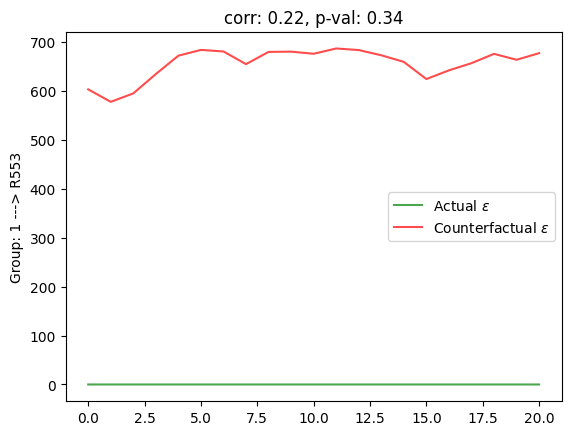

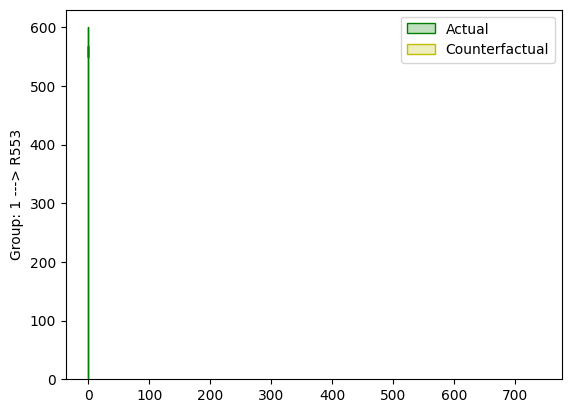

Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 1 --------------> Group: 2 (R1144)
----------*****-----------------------*****------------
Test statistic: 0.86, pv-dist: 0.0, pv-corr: 0.13, kld: 0.252
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.02
----------*****-----------------------*****------------
Causal Link: Group: 1 --------------> Group: 2 (R1144)
----------*****-----------------------*****------------
Test statistic: 0.86, pv-dist: 0.0, pv-corr: 0.13, kld: 0.252
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.03
----------*****-----------------------*****------------
Causal Link: Group: 1 --------------> Group: 2 (R1144)
----------*****-----------------------*****------------
Test statistic: 0.86, pv-dist: 0.0, pv-corr: 0.13, kld: 0.252
Null hypothesis is rejected
-----------------------------

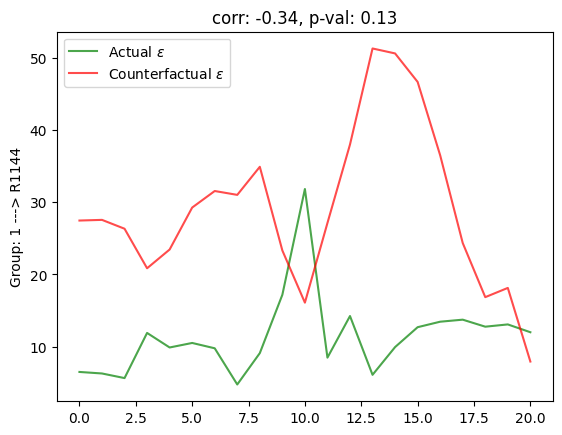

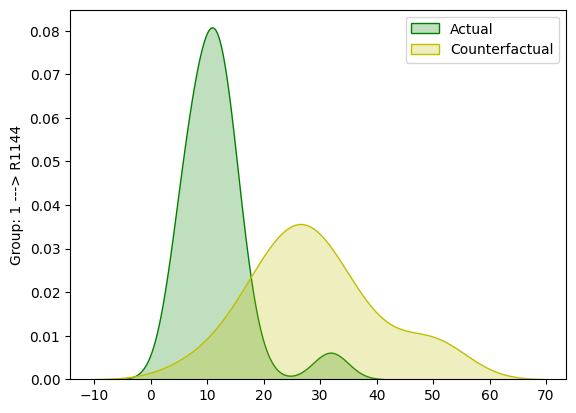

Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 1 --------------> Group: 3 (R1145)
----------*****-----------------------*****------------
Test statistic: 1.0, pv-dist: 0.0, pv-corr: 0.03, kld: 0.1
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.02
----------*****-----------------------*****------------
Causal Link: Group: 1 --------------> Group: 3 (R1145)
----------*****-----------------------*****------------
Test statistic: 1.0, pv-dist: 0.0, pv-corr: 0.03, kld: 0.1
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.03
----------*****-----------------------*****------------
Causal Link: Group: 1 --------------> Group: 3 (R1145)
----------*****-----------------------*****------------
Test statistic: 1.0, pv-dist: 0.0, pv-corr: 0.03, kld: 0.1
Null hypothesis is rejected
--------------------------------------

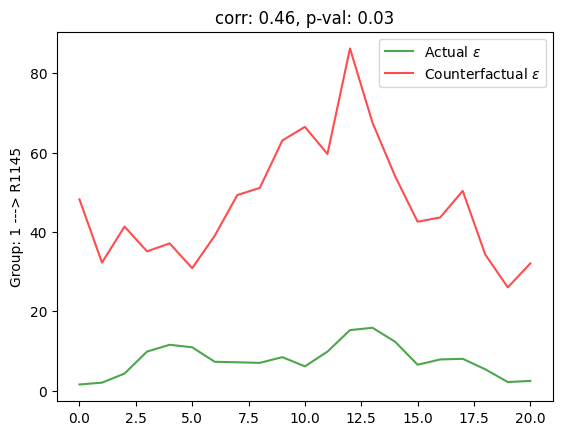

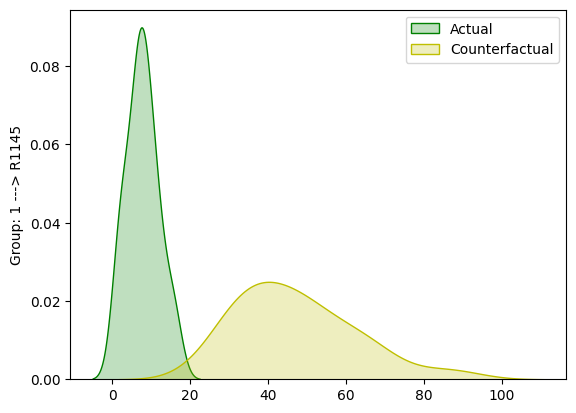

Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 1 --------------> Group: 4 (R1146)
----------*****-----------------------*****------------
Test statistic: 0.9, pv-dist: 0.0, pv-corr: 0.15, kld: 0.27
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.02
----------*****-----------------------*****------------
Causal Link: Group: 1 --------------> Group: 4 (R1146)
----------*****-----------------------*****------------
Test statistic: 0.9, pv-dist: 0.0, pv-corr: 0.15, kld: 0.27
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.03
----------*****-----------------------*****------------
Causal Link: Group: 1 --------------> Group: 4 (R1146)
----------*****-----------------------*****------------
Test statistic: 0.9, pv-dist: 0.0, pv-corr: 0.15, kld: 0.27
Null hypothesis is rejected
-----------------------------------

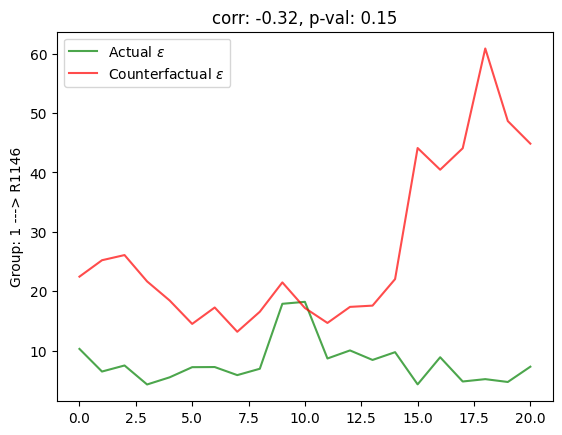

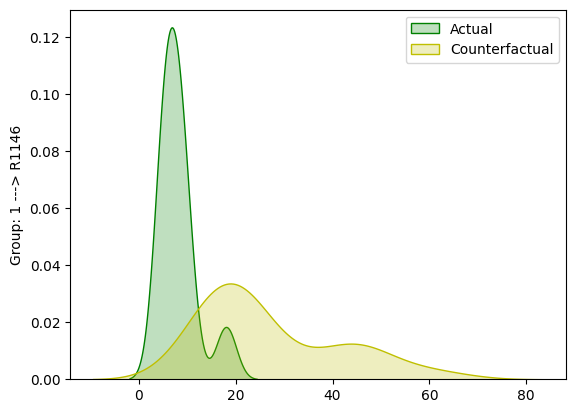

Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 1 --------------> Group: 5 (R1147)
----------*****-----------------------*****------------
Test statistic: 0.29, pv-dist: 0.36, pv-corr: 0.15, kld: 0.311
Fail to reject null hypothesis
-------------------------------------------------------
Threshold level: 0.02
----------*****-----------------------*****------------
Causal Link: Group: 1 --------------> Group: 5 (R1147)
----------*****-----------------------*****------------
Test statistic: 0.29, pv-dist: 0.36, pv-corr: 0.15, kld: 0.311
Fail to reject null hypothesis
-------------------------------------------------------
Threshold level: 0.03
----------*****-----------------------*****------------
Causal Link: Group: 1 --------------> Group: 5 (R1147)
----------*****-----------------------*****------------
Test statistic: 0.29, pv-dist: 0.36, pv-corr: 0.15, kld: 0.311
Fail to reject null hypothesis
-----------------

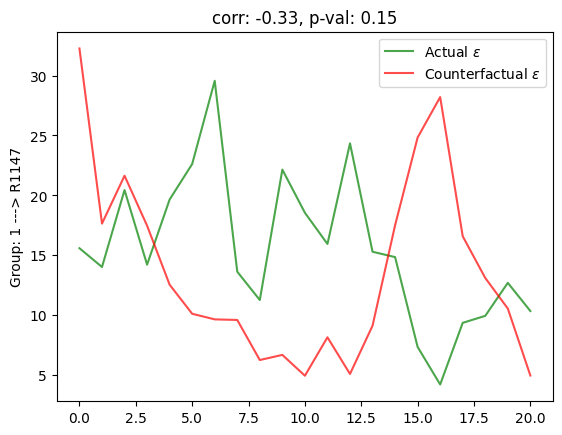

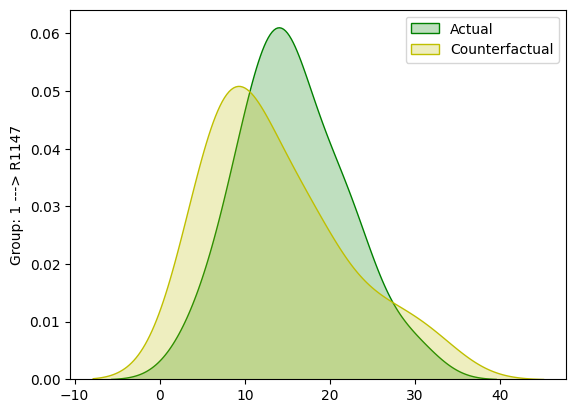

Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 2 --------------> Group: 1 (R553)
----------*****-----------------------*****------------
Test statistic: 0.95, pv-dist: 0.0, pv-corr: 0.0, kld: 0.1
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.02
----------*****-----------------------*****------------
Causal Link: Group: 2 --------------> Group: 1 (R553)
----------*****-----------------------*****------------
Test statistic: 0.95, pv-dist: 0.0, pv-corr: 0.0, kld: 0.1
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.03
----------*****-----------------------*****------------
Causal Link: Group: 2 --------------> Group: 1 (R553)
----------*****-----------------------*****------------
Test statistic: 0.95, pv-dist: 0.0, pv-corr: 0.0, kld: 0.1
Null hypothesis is rejected
-----------------------------------------

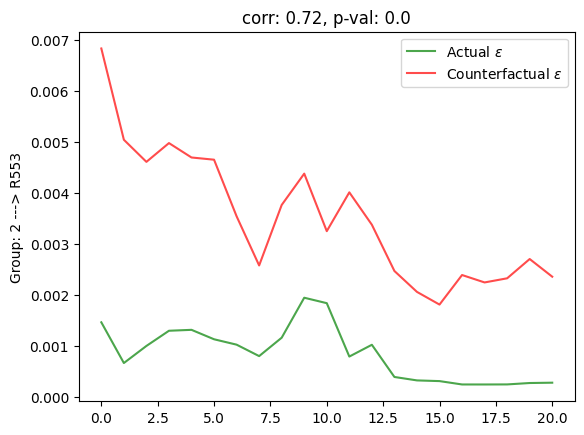

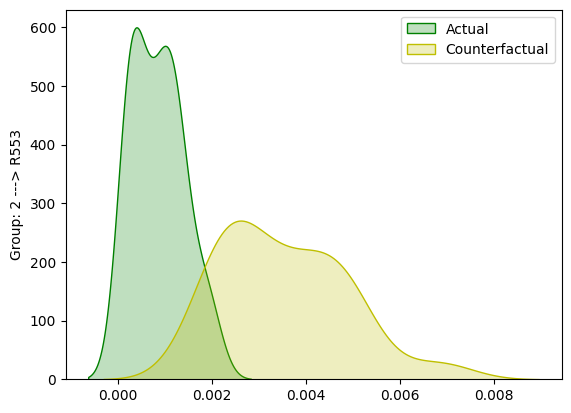

Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 2 --------------> Group: 2 (R1144)
----------*****-----------------------*****------------
Test statistic: 1.0, pv-dist: 0.0, pv-corr: 0.0, kld: 0.116
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.02
----------*****-----------------------*****------------
Causal Link: Group: 2 --------------> Group: 2 (R1144)
----------*****-----------------------*****------------
Test statistic: 1.0, pv-dist: 0.0, pv-corr: 0.0, kld: 0.116
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.03
----------*****-----------------------*****------------
Causal Link: Group: 2 --------------> Group: 2 (R1144)
----------*****-----------------------*****------------
Test statistic: 1.0, pv-dist: 0.0, pv-corr: 0.0, kld: 0.116
Null hypothesis is rejected
-----------------------------------

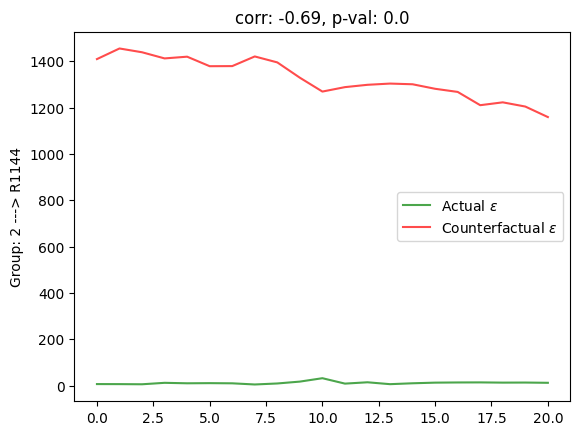

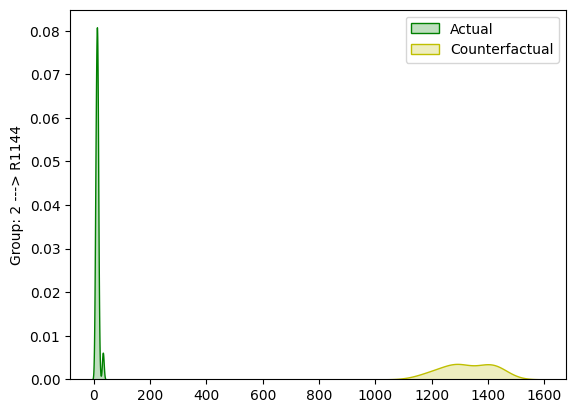

Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 2 --------------> Group: 3 (R1145)
----------*****-----------------------*****------------
Test statistic: 1.0, pv-dist: 0.0, pv-corr: 0.0, kld: 0.05
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.02
----------*****-----------------------*****------------
Causal Link: Group: 2 --------------> Group: 3 (R1145)
----------*****-----------------------*****------------
Test statistic: 1.0, pv-dist: 0.0, pv-corr: 0.0, kld: 0.05
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.03
----------*****-----------------------*****------------
Causal Link: Group: 2 --------------> Group: 3 (R1145)
----------*****-----------------------*****------------
Test statistic: 1.0, pv-dist: 0.0, pv-corr: 0.0, kld: 0.05
Null hypothesis is rejected
--------------------------------------

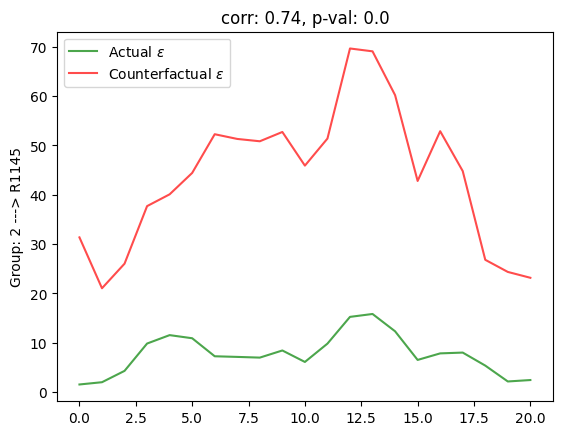

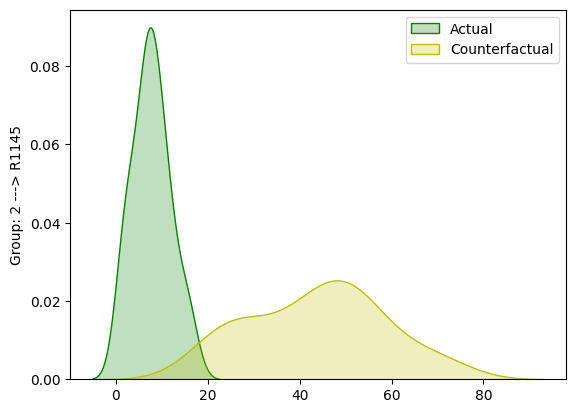

Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 2 --------------> Group: 4 (R1146)
----------*****-----------------------*****------------
Test statistic: 0.9, pv-dist: 0.0, pv-corr: 0.33, kld: 0.082
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.02
----------*****-----------------------*****------------
Causal Link: Group: 2 --------------> Group: 4 (R1146)
----------*****-----------------------*****------------
Test statistic: 0.9, pv-dist: 0.0, pv-corr: 0.33, kld: 0.082
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.03
----------*****-----------------------*****------------
Causal Link: Group: 2 --------------> Group: 4 (R1146)
----------*****-----------------------*****------------
Test statistic: 0.9, pv-dist: 0.0, pv-corr: 0.33, kld: 0.082
Null hypothesis is rejected
--------------------------------

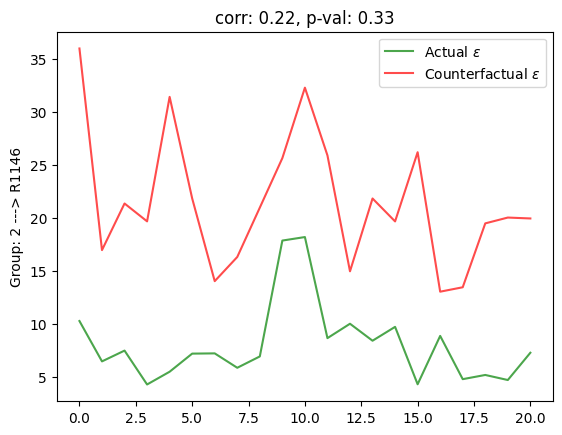

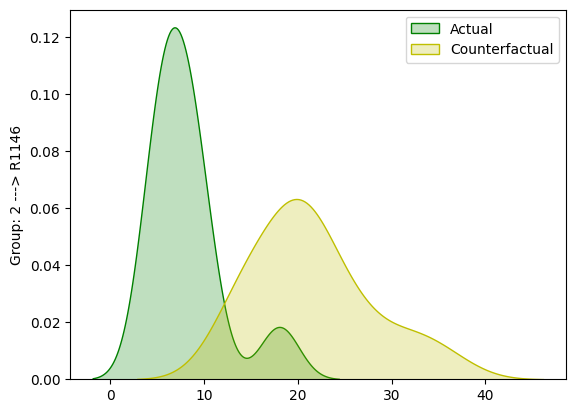

Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 2 --------------> Group: 5 (R1147)
----------*****-----------------------*****------------
Test statistic: 0.52, pv-dist: 0.01, pv-corr: 0.0, kld: 0.029
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.02
----------*****-----------------------*****------------
Causal Link: Group: 2 --------------> Group: 5 (R1147)
----------*****-----------------------*****------------
Test statistic: 0.52, pv-dist: 0.01, pv-corr: 0.0, kld: 0.029
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.03
----------*****-----------------------*****------------
Causal Link: Group: 2 --------------> Group: 5 (R1147)
----------*****-----------------------*****------------
Test statistic: 0.52, pv-dist: 0.01, pv-corr: 0.0, kld: 0.029
Null hypothesis is rejected
-----------------------------

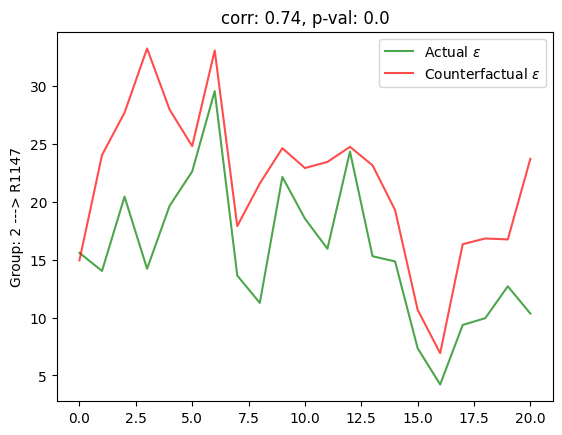

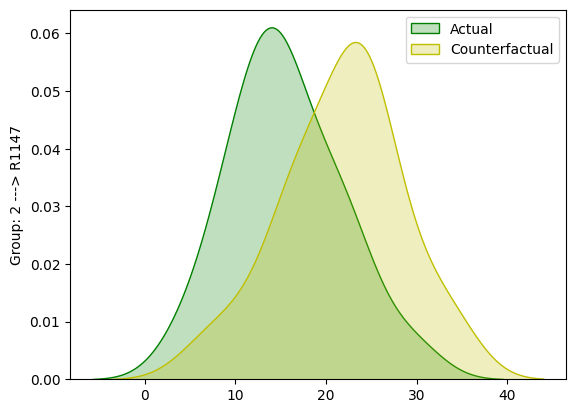

Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 3 --------------> Group: 1 (R553)
----------*****-----------------------*****------------
Test statistic: 0.14, pv-dist: 0.99, pv-corr: 0.0, kld: 0.097
Fail to reject null hypothesis
-------------------------------------------------------
Threshold level: 0.02
----------*****-----------------------*****------------
Causal Link: Group: 3 --------------> Group: 1 (R553)
----------*****-----------------------*****------------
Test statistic: 0.14, pv-dist: 0.99, pv-corr: 0.0, kld: 0.097
Fail to reject null hypothesis
-------------------------------------------------------
Threshold level: 0.03
----------*****-----------------------*****------------
Causal Link: Group: 3 --------------> Group: 1 (R553)
----------*****-----------------------*****------------
Test statistic: 0.14, pv-dist: 0.99, pv-corr: 0.0, kld: 0.097
Fail to reject null hypothesis
-----------------------

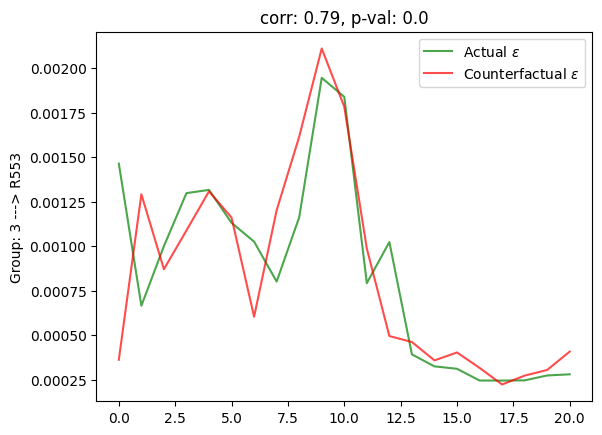

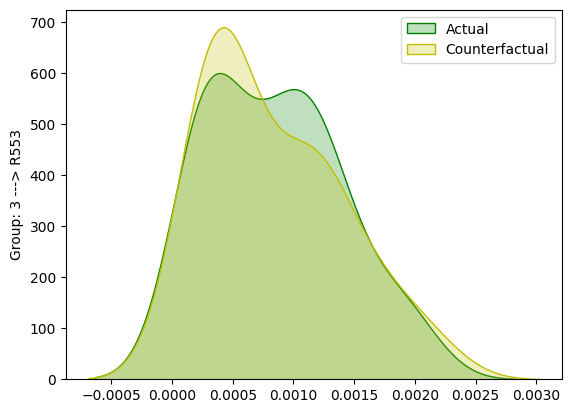

Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 3 --------------> Group: 2 (R1144)
----------*****-----------------------*****------------
Test statistic: 0.24, pv-dist: 0.6, pv-corr: 0.0, kld: 0.063
Fail to reject null hypothesis
-------------------------------------------------------
Threshold level: 0.02
----------*****-----------------------*****------------
Causal Link: Group: 3 --------------> Group: 2 (R1144)
----------*****-----------------------*****------------
Test statistic: 0.24, pv-dist: 0.6, pv-corr: 0.0, kld: 0.063
Fail to reject null hypothesis
-------------------------------------------------------
Threshold level: 0.03
----------*****-----------------------*****------------
Causal Link: Group: 3 --------------> Group: 2 (R1144)
----------*****-----------------------*****------------
Test statistic: 0.24, pv-dist: 0.6, pv-corr: 0.0, kld: 0.063
Fail to reject null hypothesis
-----------------------

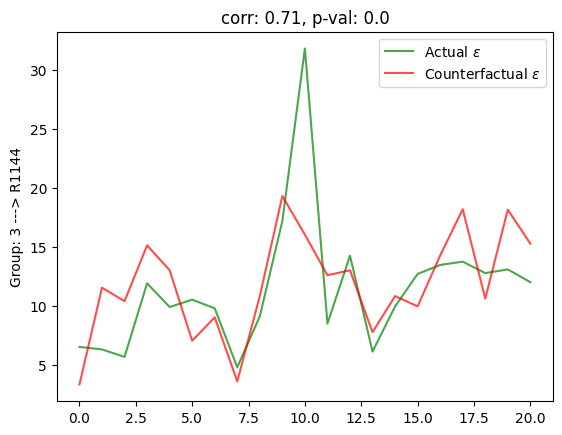

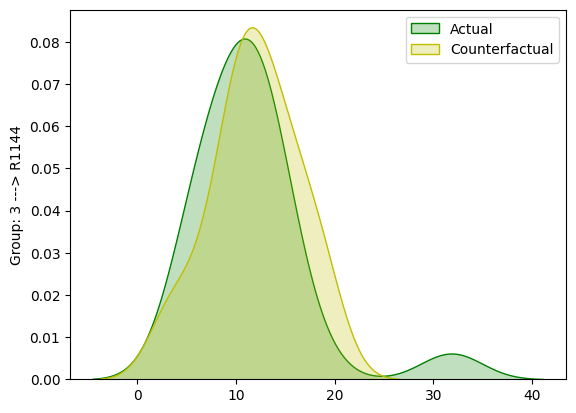

Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 3 --------------> Group: 3 (R1145)
----------*****-----------------------*****------------
Test statistic: 1.0, pv-dist: 0.0, pv-corr: 0.01, kld: 0.175
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.02
----------*****-----------------------*****------------
Causal Link: Group: 3 --------------> Group: 3 (R1145)
----------*****-----------------------*****------------
Test statistic: 1.0, pv-dist: 0.0, pv-corr: 0.01, kld: 0.175
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.03
----------*****-----------------------*****------------
Causal Link: Group: 3 --------------> Group: 3 (R1145)
----------*****-----------------------*****------------
Test statistic: 1.0, pv-dist: 0.0, pv-corr: 0.01, kld: 0.175
Null hypothesis is rejected
--------------------------------

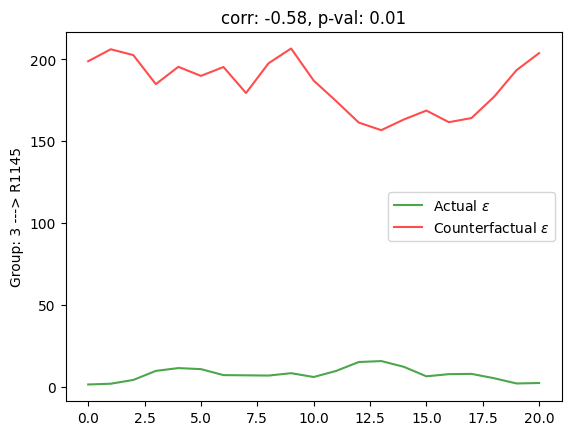

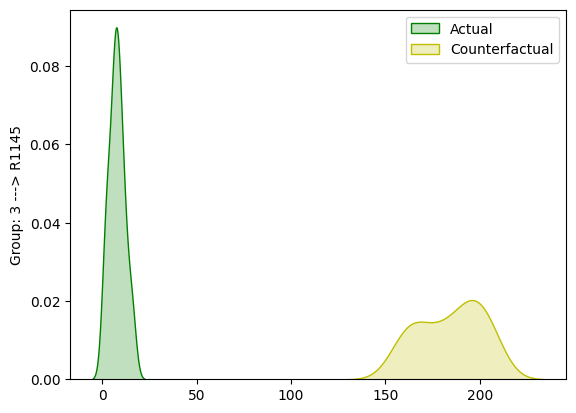

Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 3 --------------> Group: 4 (R1146)
----------*****-----------------------*****------------
Test statistic: 0.29, pv-dist: 0.36, pv-corr: 0.0, kld: 0.106
Fail to reject null hypothesis
-------------------------------------------------------
Threshold level: 0.02
----------*****-----------------------*****------------
Causal Link: Group: 3 --------------> Group: 4 (R1146)
----------*****-----------------------*****------------
Test statistic: 0.29, pv-dist: 0.36, pv-corr: 0.0, kld: 0.106
Fail to reject null hypothesis
-------------------------------------------------------
Threshold level: 0.03
----------*****-----------------------*****------------
Causal Link: Group: 3 --------------> Group: 4 (R1146)
----------*****-----------------------*****------------
Test statistic: 0.29, pv-dist: 0.36, pv-corr: 0.0, kld: 0.106
Fail to reject null hypothesis
--------------------

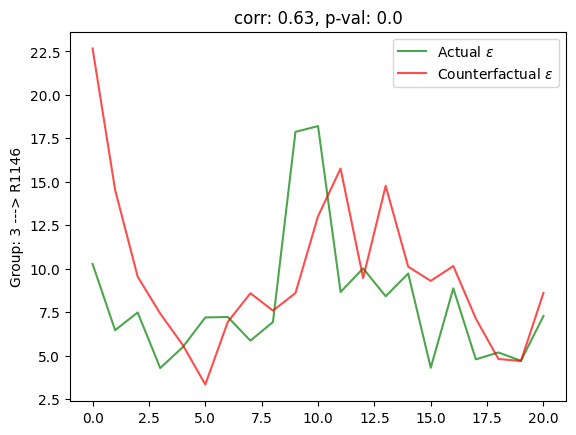

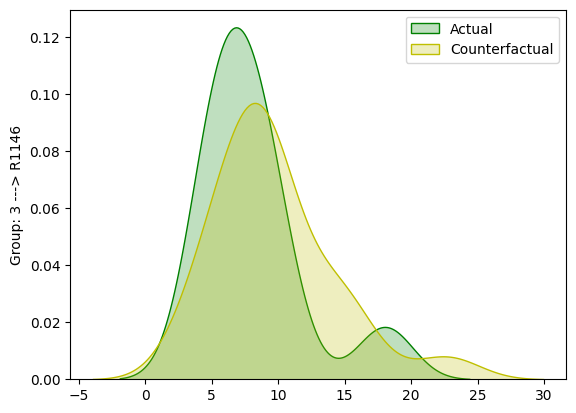

Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 3 --------------> Group: 5 (R1147)
----------*****-----------------------*****------------
Test statistic: 0.24, pv-dist: 0.6, pv-corr: 0.0, kld: 0.024
Fail to reject null hypothesis
-------------------------------------------------------
Threshold level: 0.02
----------*****-----------------------*****------------
Causal Link: Group: 3 --------------> Group: 5 (R1147)
----------*****-----------------------*****------------
Test statistic: 0.24, pv-dist: 0.6, pv-corr: 0.0, kld: 0.024
Fail to reject null hypothesis
-------------------------------------------------------
Threshold level: 0.03
----------*****-----------------------*****------------
Causal Link: Group: 3 --------------> Group: 5 (R1147)
----------*****-----------------------*****------------
Test statistic: 0.24, pv-dist: 0.6, pv-corr: 0.0, kld: 0.024
Fail to reject null hypothesis
-----------------------

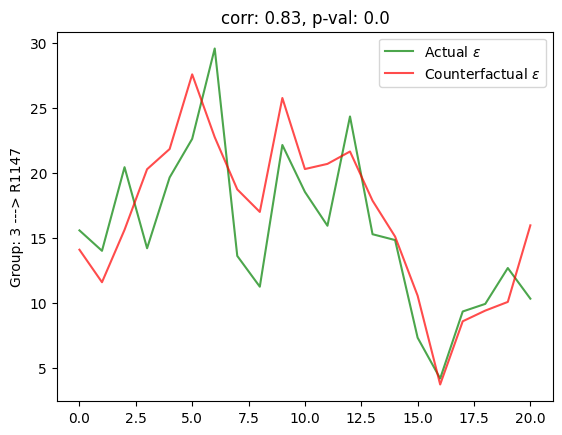

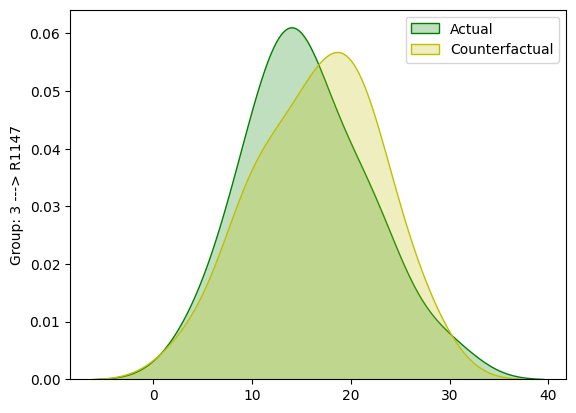

Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 4 --------------> Group: 1 (R553)
----------*****-----------------------*****------------
Test statistic: 0.19, pv-dist: 0.85, pv-corr: 0.0, kld: 0.034
Fail to reject null hypothesis
-------------------------------------------------------
Threshold level: 0.02
----------*****-----------------------*****------------
Causal Link: Group: 4 --------------> Group: 1 (R553)
----------*****-----------------------*****------------
Test statistic: 0.19, pv-dist: 0.85, pv-corr: 0.0, kld: 0.034
Fail to reject null hypothesis
-------------------------------------------------------
Threshold level: 0.03
----------*****-----------------------*****------------
Causal Link: Group: 4 --------------> Group: 1 (R553)
----------*****-----------------------*****------------
Test statistic: 0.19, pv-dist: 0.85, pv-corr: 0.0, kld: 0.034
Fail to reject null hypothesis
-----------------------

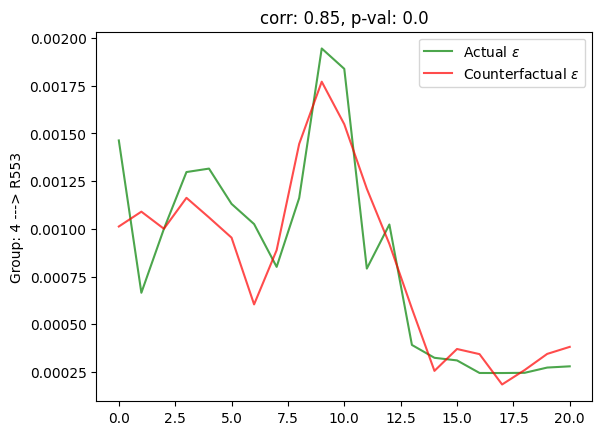

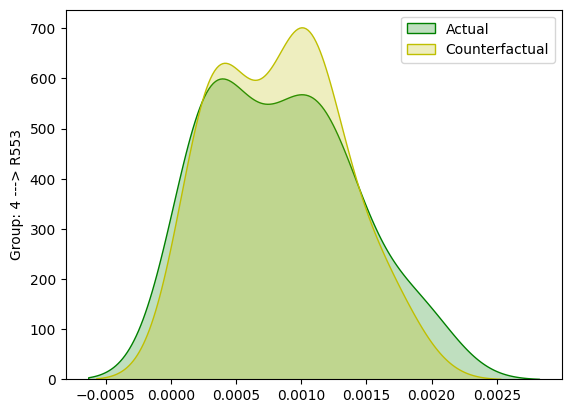

Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 4 --------------> Group: 2 (R1144)
----------*****-----------------------*****------------
Test statistic: 0.19, pv-dist: 0.85, pv-corr: 0.0, kld: 0.043
Fail to reject null hypothesis
-------------------------------------------------------
Threshold level: 0.02
----------*****-----------------------*****------------
Causal Link: Group: 4 --------------> Group: 2 (R1144)
----------*****-----------------------*****------------
Test statistic: 0.19, pv-dist: 0.85, pv-corr: 0.0, kld: 0.043
Fail to reject null hypothesis
-------------------------------------------------------
Threshold level: 0.03
----------*****-----------------------*****------------
Causal Link: Group: 4 --------------> Group: 2 (R1144)
----------*****-----------------------*****------------
Test statistic: 0.19, pv-dist: 0.85, pv-corr: 0.0, kld: 0.043
Fail to reject null hypothesis
--------------------

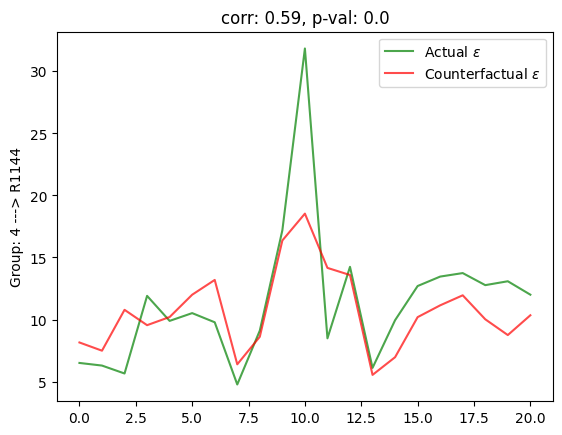

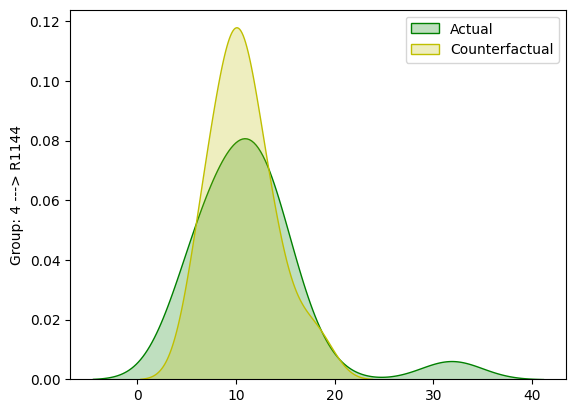

Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 4 --------------> Group: 3 (R1145)
----------*****-----------------------*****------------
Test statistic: 0.14, pv-dist: 0.99, pv-corr: 0.0, kld: 0.028
Fail to reject null hypothesis
-------------------------------------------------------
Threshold level: 0.02
----------*****-----------------------*****------------
Causal Link: Group: 4 --------------> Group: 3 (R1145)
----------*****-----------------------*****------------
Test statistic: 0.14, pv-dist: 0.99, pv-corr: 0.0, kld: 0.028
Fail to reject null hypothesis
-------------------------------------------------------
Threshold level: 0.03
----------*****-----------------------*****------------
Causal Link: Group: 4 --------------> Group: 3 (R1145)
----------*****-----------------------*****------------
Test statistic: 0.14, pv-dist: 0.99, pv-corr: 0.0, kld: 0.028
Fail to reject null hypothesis
--------------------

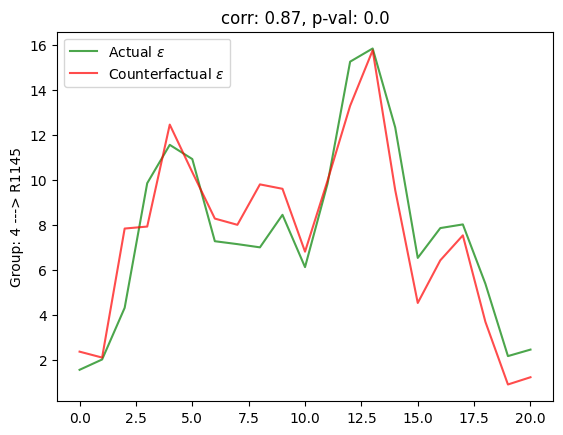

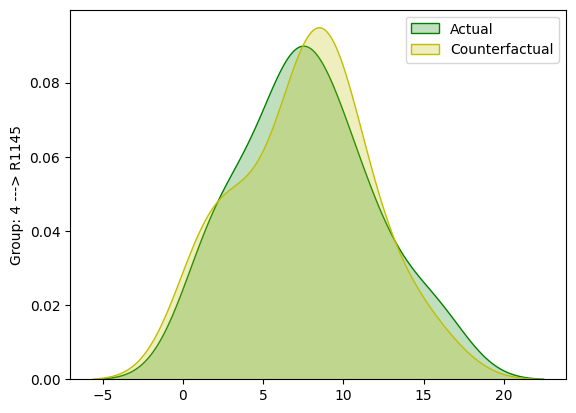

Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 4 --------------> Group: 4 (R1146)
----------*****-----------------------*****------------
Test statistic: 1.0, pv-dist: 0.0, pv-corr: 0.01, kld: 0.163
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.02
----------*****-----------------------*****------------
Causal Link: Group: 4 --------------> Group: 4 (R1146)
----------*****-----------------------*****------------
Test statistic: 1.0, pv-dist: 0.0, pv-corr: 0.01, kld: 0.163
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.03
----------*****-----------------------*****------------
Causal Link: Group: 4 --------------> Group: 4 (R1146)
----------*****-----------------------*****------------
Test statistic: 1.0, pv-dist: 0.0, pv-corr: 0.01, kld: 0.163
Null hypothesis is rejected
--------------------------------

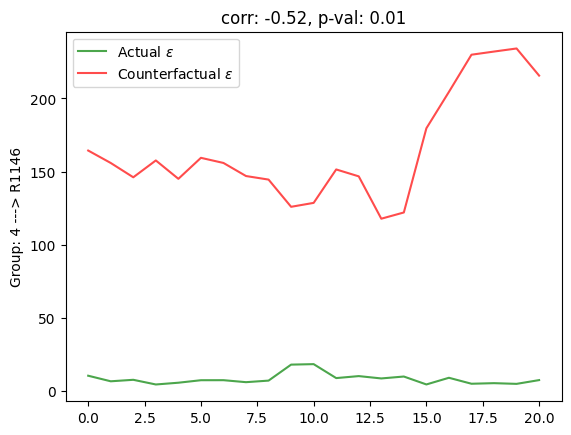

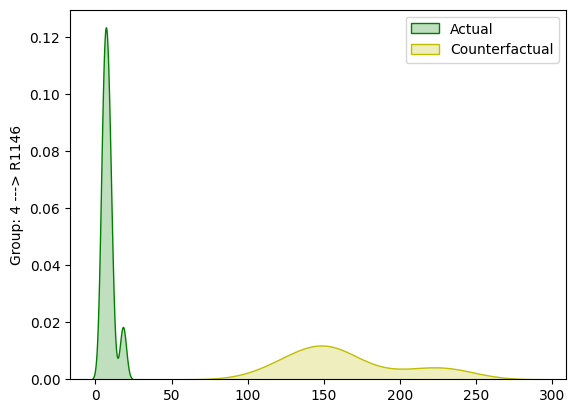

Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 4 --------------> Group: 5 (R1147)
----------*****-----------------------*****------------
Test statistic: 0.24, pv-dist: 0.6, pv-corr: 0.0, kld: 0.023
Fail to reject null hypothesis
-------------------------------------------------------
Threshold level: 0.02
----------*****-----------------------*****------------
Causal Link: Group: 4 --------------> Group: 5 (R1147)
----------*****-----------------------*****------------
Test statistic: 0.24, pv-dist: 0.6, pv-corr: 0.0, kld: 0.023
Fail to reject null hypothesis
-------------------------------------------------------
Threshold level: 0.03
----------*****-----------------------*****------------
Causal Link: Group: 4 --------------> Group: 5 (R1147)
----------*****-----------------------*****------------
Test statistic: 0.24, pv-dist: 0.6, pv-corr: 0.0, kld: 0.023
Fail to reject null hypothesis
-----------------------

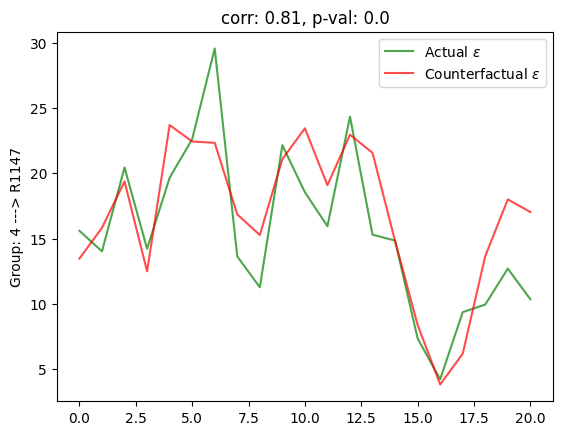

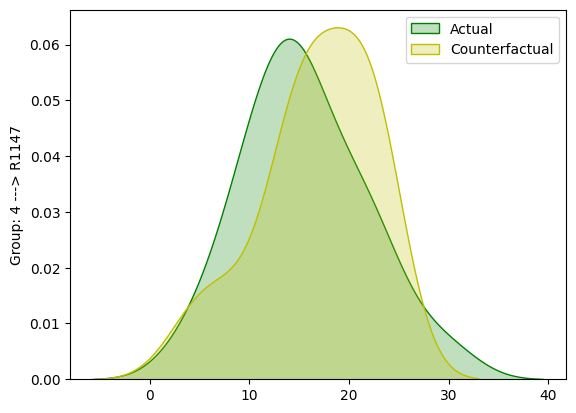

Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 5 --------------> Group: 1 (R553)
----------*****-----------------------*****------------
Test statistic: 0.43, pv-dist: 0.04, pv-corr: 0.0, kld: 0.052
Fail to reject null hypothesis
-------------------------------------------------------
Threshold level: 0.02
----------*****-----------------------*****------------
Causal Link: Group: 5 --------------> Group: 1 (R553)
----------*****-----------------------*****------------
Test statistic: 0.43, pv-dist: 0.04, pv-corr: 0.0, kld: 0.052
Fail to reject null hypothesis
-------------------------------------------------------
Threshold level: 0.03
----------*****-----------------------*****------------
Causal Link: Group: 5 --------------> Group: 1 (R553)
----------*****-----------------------*****------------
Test statistic: 0.43, pv-dist: 0.04, pv-corr: 0.0, kld: 0.052
Fail to reject null hypothesis
-----------------------

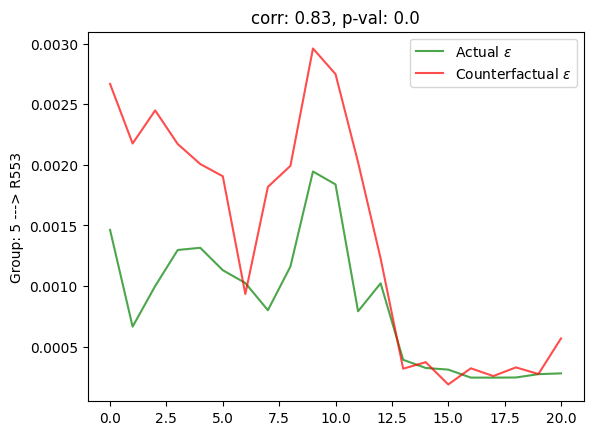

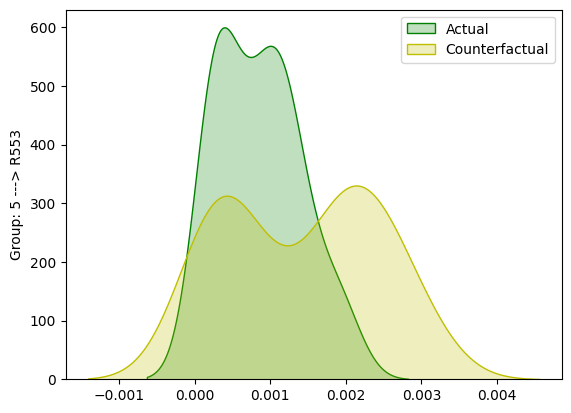

Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 5 --------------> Group: 2 (R1144)
----------*****-----------------------*****------------
Test statistic: 0.76, pv-dist: 0.0, pv-corr: 0.06, kld: 0.054
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.02
----------*****-----------------------*****------------
Causal Link: Group: 5 --------------> Group: 2 (R1144)
----------*****-----------------------*****------------
Test statistic: 0.76, pv-dist: 0.0, pv-corr: 0.06, kld: 0.054
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.03
----------*****-----------------------*****------------
Causal Link: Group: 5 --------------> Group: 2 (R1144)
----------*****-----------------------*****------------
Test statistic: 0.76, pv-dist: 0.0, pv-corr: 0.06, kld: 0.054
Null hypothesis is rejected
-----------------------------

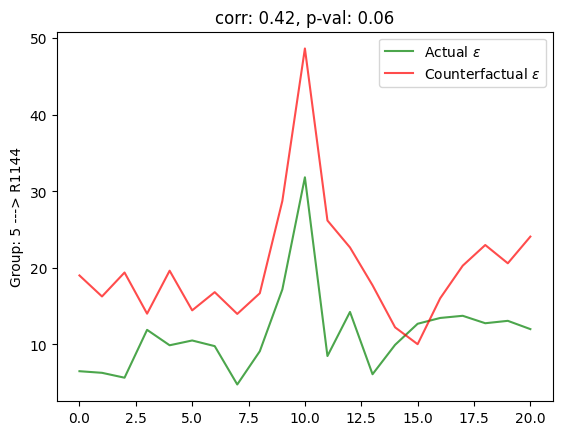

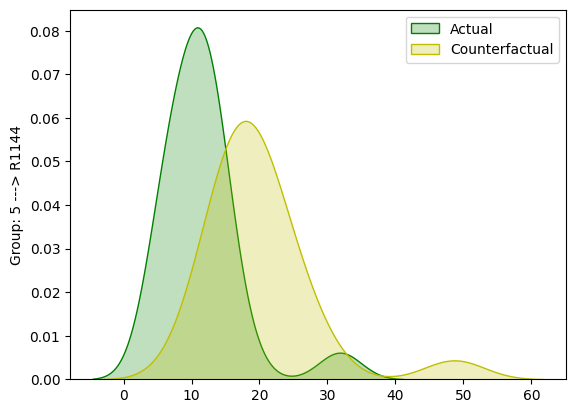

Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 5 --------------> Group: 3 (R1145)
----------*****-----------------------*****------------
Test statistic: 0.14, pv-dist: 0.99, pv-corr: 0.01, kld: 0.1
Fail to reject null hypothesis
-------------------------------------------------------
Threshold level: 0.02
----------*****-----------------------*****------------
Causal Link: Group: 5 --------------> Group: 3 (R1145)
----------*****-----------------------*****------------
Test statistic: 0.14, pv-dist: 0.99, pv-corr: 0.01, kld: 0.1
Fail to reject null hypothesis
-------------------------------------------------------
Threshold level: 0.03
----------*****-----------------------*****------------
Causal Link: Group: 5 --------------> Group: 3 (R1145)
----------*****-----------------------*****------------
Test statistic: 0.14, pv-dist: 0.99, pv-corr: 0.01, kld: 0.1
Fail to reject null hypothesis
-----------------------

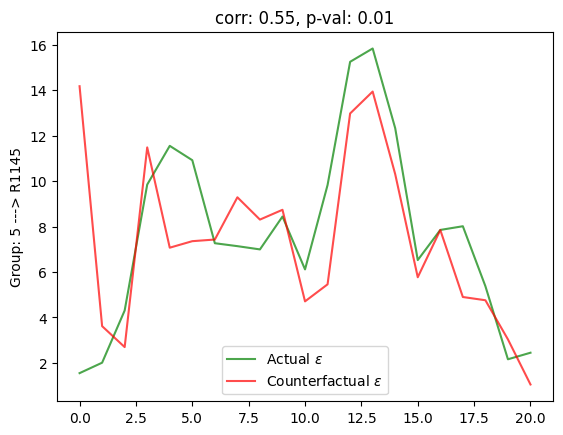

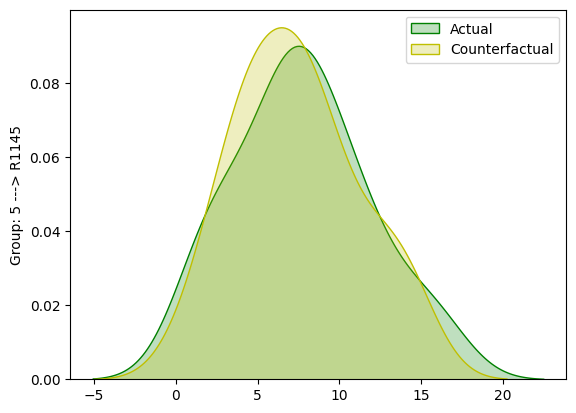

Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 5 --------------> Group: 4 (R1146)
----------*****-----------------------*****------------
Test statistic: 0.48, pv-dist: 0.02, pv-corr: 0.34, kld: 0.198
Fail to reject null hypothesis
-------------------------------------------------------
Threshold level: 0.02
----------*****-----------------------*****------------
Causal Link: Group: 5 --------------> Group: 4 (R1146)
----------*****-----------------------*****------------
Test statistic: 0.48, pv-dist: 0.02, pv-corr: 0.34, kld: 0.198
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.03
----------*****-----------------------*****------------
Causal Link: Group: 5 --------------> Group: 4 (R1146)
----------*****-----------------------*****------------
Test statistic: 0.48, pv-dist: 0.02, pv-corr: 0.34, kld: 0.198
Null hypothesis is rejected
-----------------------

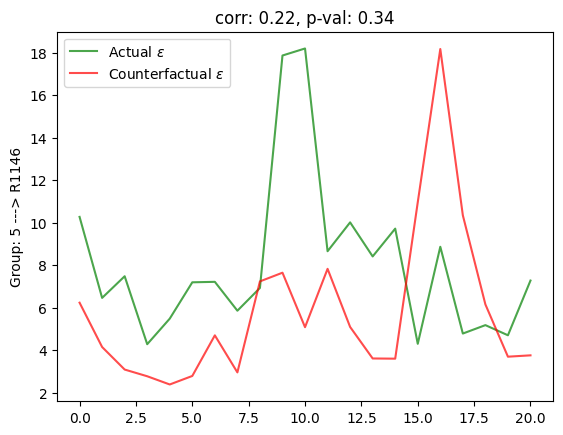

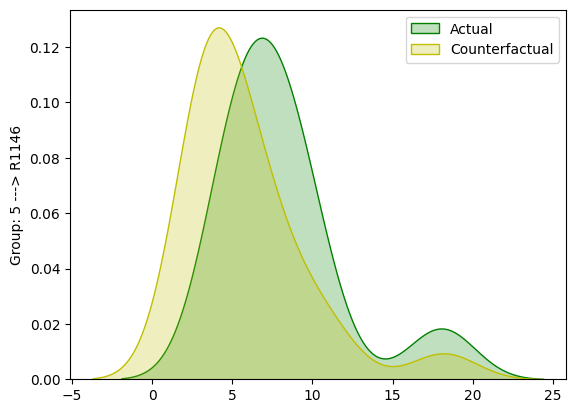

Intervention: In-dist
Threshold level: 0.01
----------*****-----------------------*****------------
Causal Link: Group: 5 --------------> Group: 5 (R1147)
----------*****-----------------------*****------------
Test statistic: 1.0, pv-dist: 0.0, pv-corr: 0.01, kld: 0.099
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.02
----------*****-----------------------*****------------
Causal Link: Group: 5 --------------> Group: 5 (R1147)
----------*****-----------------------*****------------
Test statistic: 1.0, pv-dist: 0.0, pv-corr: 0.01, kld: 0.099
Null hypothesis is rejected
-------------------------------------------------------
Threshold level: 0.03
----------*****-----------------------*****------------
Causal Link: Group: 5 --------------> Group: 5 (R1147)
----------*****-----------------------*****------------
Test statistic: 1.0, pv-dist: 0.0, pv-corr: 0.01, kld: 0.099
Null hypothesis is rejected
--------------------------------

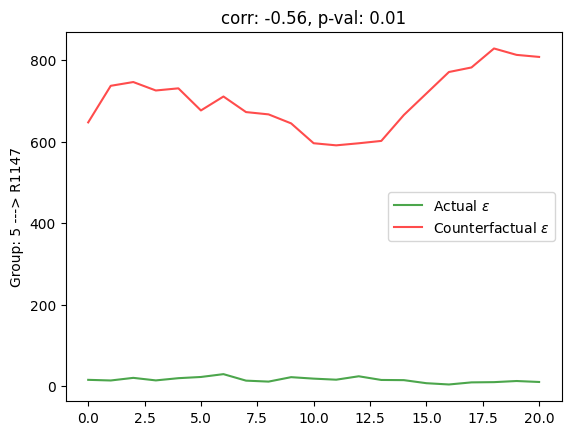

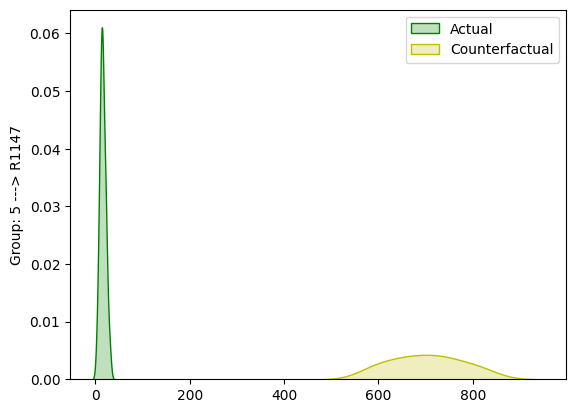

Separated matrices:

Causal Graph 1:
[[1 1 1 1 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 1 0 0 1]]

Causal Graph 2:
[[1 1 1 1 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 1 0 1 1]]

Causal Graph 3:
[[1 1 1 1 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 1 0 1 1]]

Causal Graph 4:
[[1 1 1 1 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 1 0 1 1]]

Causal Graph 5:
[[1 1 1 1 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [1 1 0 1 1]]

Causal Graph 6:
[[1 1 1 1 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [1 1 0 1 1]]

Causal Graph 7:
[[1 1 1 1 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [1 1 0 1 1]]

Causal Graph 8:
[[1 1 1 1 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [1 1 0 1 1]]

Causal Graph 9:
[[1 1 1 1 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [1 1 0 1 1]]

Causal Graph 10:
[[1 1 1 1 0]
 [1 1 1 1 1]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [1 1 0 1 1]]
--------------------------------------------------------
Actual Causal Graph: 
 [[1 1 0 0 0]
 [0 1 0 0 0]
 [0 1 1 0 0]
 [0 0 1 1 0]
 [0 0 0 1 1]]
Cau

{'TPR': 0.7777777777777778,
 'TNR': 0.5625,
 'FPR': 0.4375,
 'FNR': 0.2222222222222222,
 'Accuracy': 0.64,
 'Precision': 0.5,
 'Recall': 0.7777777777777778,
 'Fscore': 0.6086956521739131,
 'SHD': 9}

In [226]:
# Function for estimating causal impact among variables
method_type = 'Full'
group_size_list = [value[0] for value in pars['groups_size'].values()]
# ground_truth = gcdmi.get_ground_truth(ground_truth, group_size_list)
metrics, predicted_graph, predicted_graph_t1 = groupCause(original_data, knockoffs, model_path, pars, ground_truth, method_type)
metrics

#### Computation Time

In [ ]:
# # Calculate difference
# elapsed_time = end_time - start_time
# # Print elapsed time
# print("Computation time: ", round(elapsed_time/60), "mins")